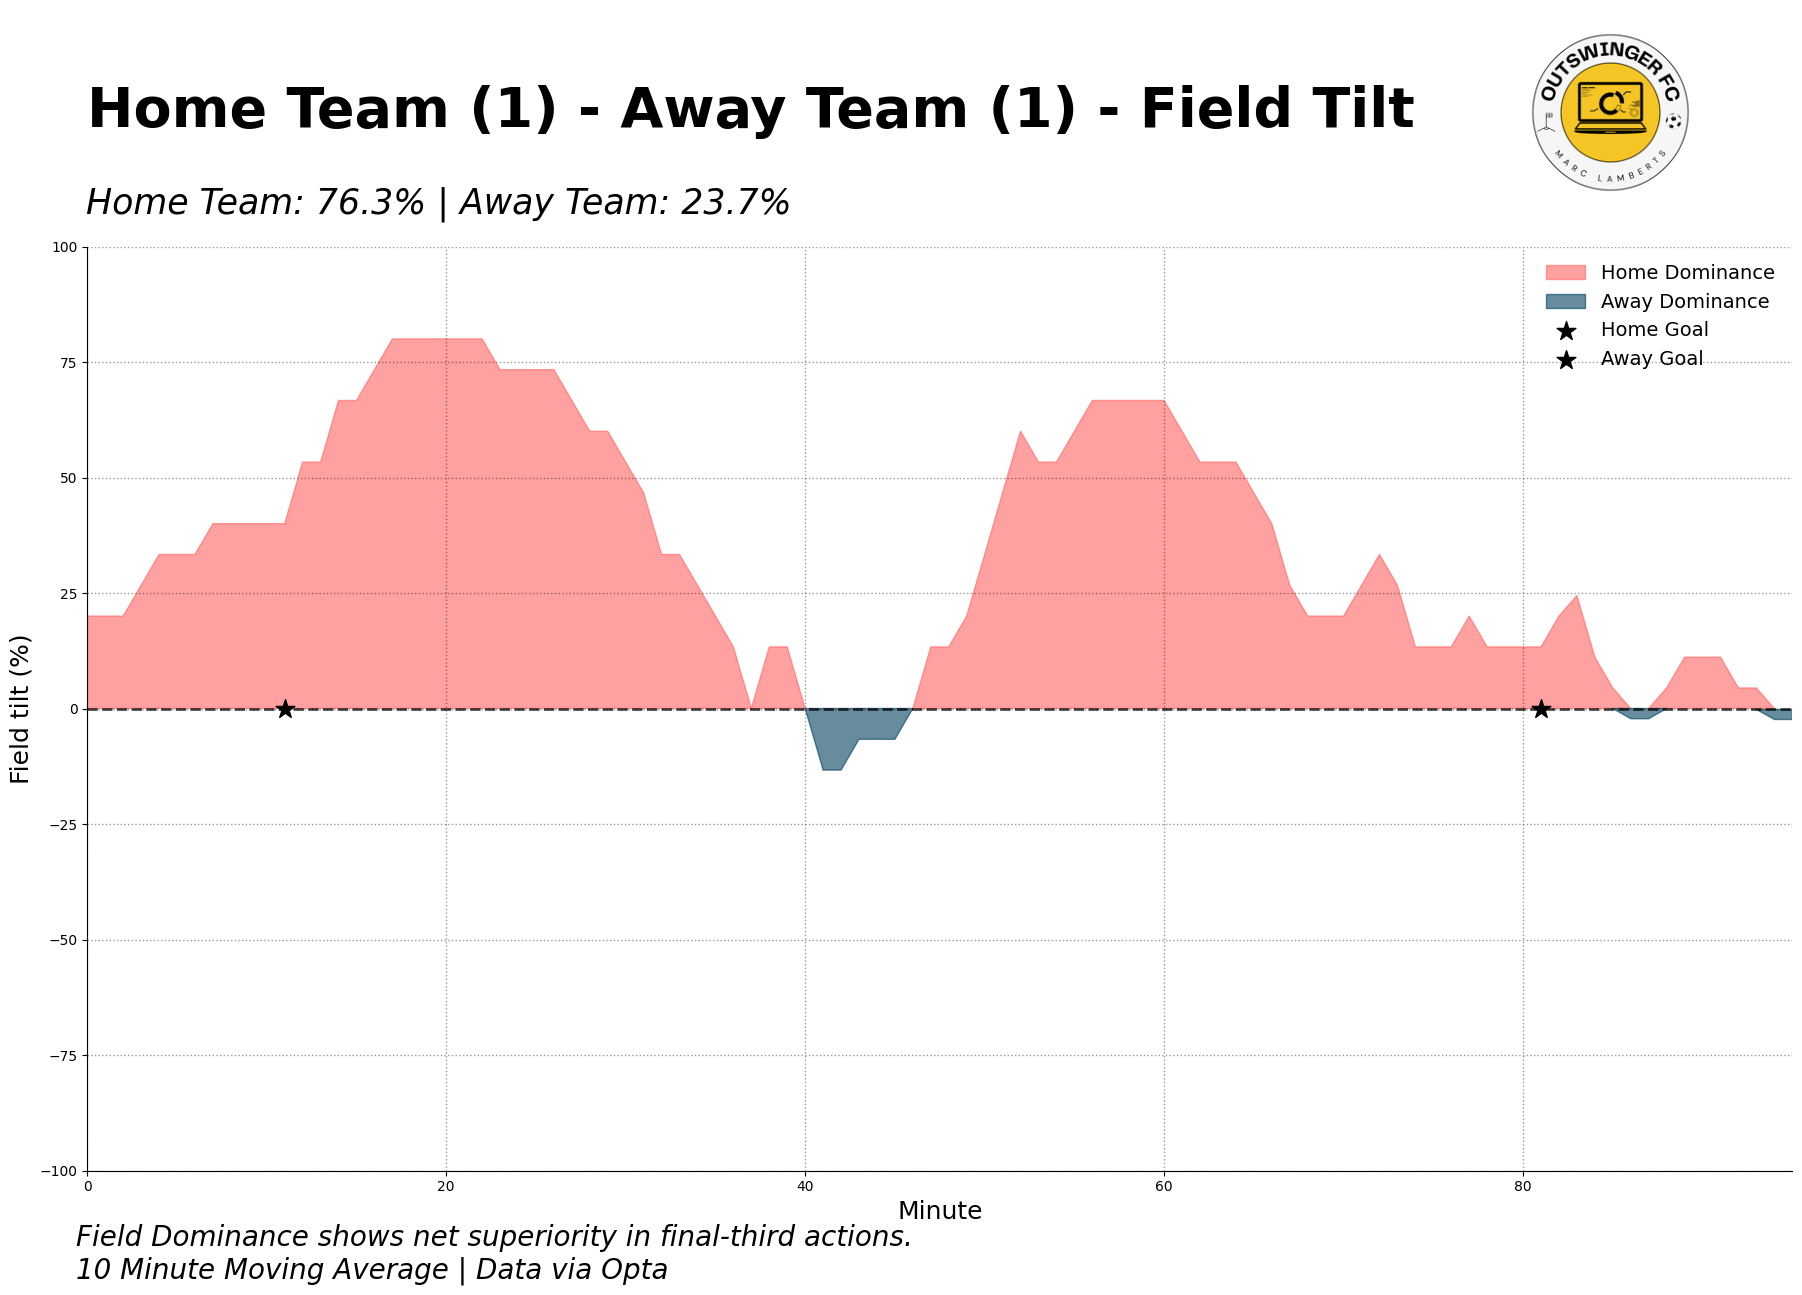

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# Load data
file_path = '/Users/marclambertes/Python/Matches/Women/2024-2025/Eredivisie/Feyenoord 1-1 Willem II.csv' 
df = pd.read_csv(file_path)

# Assign team IDs for home and away teams
hteam_id = '20vymiy7bo8wkyxai3ew494fz'  # Home team ID
ateam_id = 'bk5ltsueqmeng29eovd8m2tml'  # Away team ID

# Filter final third passes
df_final_third = df.loc[(df['typeId'] == 1) & (df['x'] > 70)]  # Passes in the final third

# Group by teams and count final third passes
final_third_count = df_final_third.groupby('contestantId').size().reset_index(name='Final third passes')

# Calculate total final third passes
total_final_third_passes = final_third_count['Final third passes'].sum()

# Add Field Tilt for each team
final_third_count['Field Tilt'] = (final_third_count['Final third passes'] / total_final_third_passes) * 100

# Initialize lists for minute-by-minute Field Tilt
minutes = list(range(0, 96))  # 0-95 minutes
home_tilt = []
away_tilt = []

# Compute Field Tilt per minute
for minute in minutes:
    home_passes = df_final_third[(df_final_third['contestantId'] == hteam_id) & (df_final_third['timeMin'] == minute)].shape[0]
    away_passes = df_final_third[(df_final_third['contestantId'] == ateam_id) & (df_final_third['timeMin'] == minute)].shape[0]
    
    total_passes = home_passes + away_passes
    if total_passes == 0:
        home_tilt.append(0)  # Neutral if no attacking passes
        away_tilt.append(0)
    else:
        home_tilt.append((home_passes / total_passes) * 100)
        away_tilt.append(-1 * (away_passes / total_passes) * 100)  # Make away team values negative

# Smooth the Field Tilt using a larger moving average window
def moving_average(values, window):
    return np.convolve(values, np.ones(window) / window, mode='same')

home_tilt_smoothed = moving_average(home_tilt, 15)  # Larger window for rounder curves
away_tilt_smoothed = moving_average(away_tilt, 15)

# Calculate total attacking contributions for percentages
home_total = sum([x for x in home_tilt if x > 0])
away_total = sum([-x for x in away_tilt if x < 0])  # Convert negative values to positive
overall_total = home_total + away_total

home_percentage = (home_total / overall_total) * 100
away_percentage = (away_total / overall_total) * 100

# Calculate net dominance
net_tilt = np.maximum(home_tilt_smoothed + away_tilt_smoothed, 0)  # Positive area for home
net_tilt_away = np.minimum(home_tilt_smoothed + away_tilt_smoothed, 0)  # Negative area for away

# Goals for context
home_goals_min = df[(df['contestantId'] == hteam_id) & (df['typeId'] == 16)]['timeMin'].tolist()
away_goals_min = df[(df['contestantId'] == ateam_id) & (df['typeId'] == 16)]['timeMin'].tolist()

# Plot Field Dominance
fig, ax = plt.subplots(figsize=(22, 12))  # Increased plot size here
fig.set_facecolor('white')
ax.patch.set_facecolor('white')

# Grid and aesthetics
ax.grid(ls='dotted', lw=1, color='black', alpha=0.4, zorder=1)
ax.axhline(0, color='black', linestyle='dashed', linewidth=2, alpha=0.7)  # 0% line

# Fill regions based on net dominance
ax.fill_between(minutes, 0, net_tilt, where=(net_tilt > 0), interpolate=True, color='#ff6361', alpha=0.6, label='Home Dominance')
ax.fill_between(minutes, 0, net_tilt_away, where=(net_tilt_away < 0), interpolate=True, color='#003f5c', alpha=0.6, label='Away Dominance')

# Add goal markers
for goal in home_goals_min:
    ax.scatter(goal, 0, color='black', marker='*', s=200, label='Home Goal')

for goal in away_goals_min:
    ax.scatter(goal, 0, color='black', marker='*', s=200, label='Away Goal')

# Add logo in the top-right corner
logo_path = 'Outswinger FC (3).png'  # Replace with the path to your logo file
logo_img = mpimg.imread(logo_path)  # Read the logo image
imagebox = OffsetImage(logo_img, zoom=0.7)  # Adjust zoom to control logo size
ab = AnnotationBbox(imagebox, (0.95, 1.25), frameon=False, xycoords='axes fraction', box_alignment=(1, 1))
ax.add_artist(ab)

# Title and subtitles
title = f"Home Team ({len(home_goals_min)}) - Away Team ({len(away_goals_min)}) - Field Tilt"
subtitle = f"Home Team: {home_percentage:.1f}% | Away Team: {away_percentage:.1f}%"
footer = "Field Dominance shows net superiority in final-third actions.\n10 Minute Moving Average | Data via Opta"

# Adjust the title and subtitle positions by increasing the `y` value
plt.title(title, fontsize=40, color='black', weight='bold', loc='left', y=1.12)  # Higher title
plt.suptitle(subtitle, fontsize=25, color='black', style='italic', x=0.285, y=0.93)  # Higher subtitle
fig.text(0.12, 0.02, footer, fontsize=20, color='black', style='italic')  # Larger footer text

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labels and limits
plt.xlabel('Minute', fontsize=18)  # Larger font size for labels
plt.ylabel('Field tilt (%)', fontsize=18)
plt.ylim(-100, 100)
plt.xlim(0, 95)

# Legend
ax.legend(loc='upper right', fontsize=14, frameon=False)  # Larger legend

# Save and display
plt.savefig('field_dominance_chart_with_logo.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


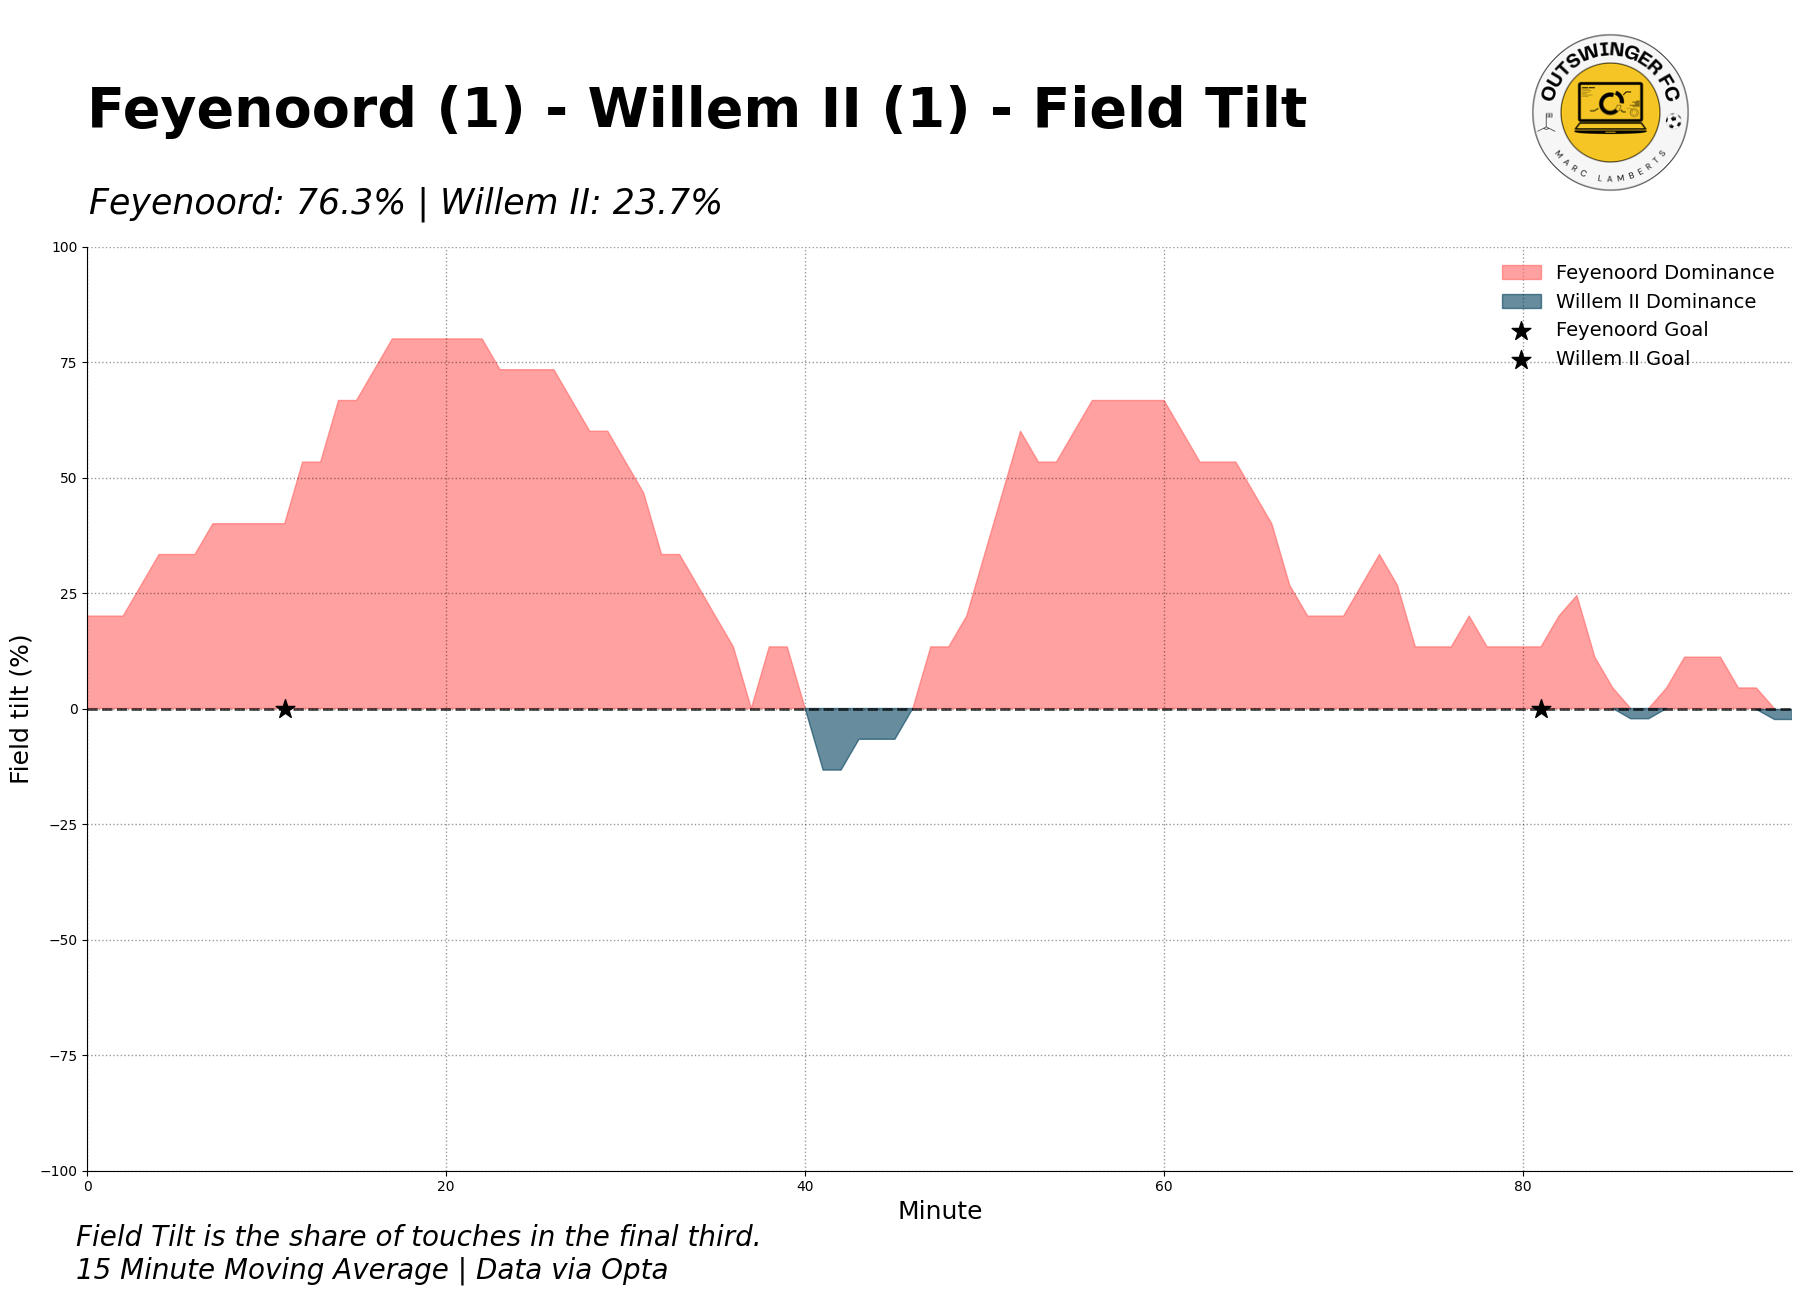

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# Load match data
file_path = '/Users/marclambertes/Python/Matches/Women/2024-2025/Eredivisie/Feyenoord 1-1 Willem II.csv' 
df = pd.read_csv(file_path)

# Load the team mapping file
mapping_file_path = '/Users/marclambertes/Downloads/opta_club_rankings_19012025.xlsx'  # Replace with your mapping file path
mapping_df = pd.read_excel(mapping_file_path)  # Assuming it has columns 'id' and 'team'

# Create a dictionary to map 'id' to 'team'
id_to_team = dict(zip(mapping_df['id'], mapping_df['team']))

# Assign team IDs for home and away teams
hteam_id = '20vymiy7bo8wkyxai3ew494fz'  # Home team ID
ateam_id = 'bk5ltsueqmeng29eovd8m2tml'  # Away team ID

# Get the corresponding team names
hteam_name = id_to_team.get(hteam_id, 'Unknown Team')  # Default to 'Unknown Team' if not found
ateam_name = id_to_team.get(ateam_id, 'Unknown Team')

# Filter final third passes
df_final_third = df.loc[(df['typeId'] == 1) & (df['x'] > 70)]  # Passes in the final third

# Group by teams and count final third passes
final_third_count = df_final_third.groupby('contestantId').size().reset_index(name='Final third passes')

# Calculate total final third passes
total_final_third_passes = final_third_count['Final third passes'].sum()

# Add Field Tilt for each team
final_third_count['Field Tilt'] = (final_third_count['Final third passes'] / total_final_third_passes) * 100

# Initialize lists for minute-by-minute Field Tilt
minutes = list(range(0, 96))  # 0-95 minutes
home_tilt = []
away_tilt = []

# Compute Field Tilt per minute
for minute in minutes:
    home_passes = df_final_third[(df_final_third['contestantId'] == hteam_id) & (df_final_third['timeMin'] == minute)].shape[0]
    away_passes = df_final_third[(df_final_third['contestantId'] == ateam_id) & (df_final_third['timeMin'] == minute)].shape[0]
    
    total_passes = home_passes + away_passes
    if total_passes == 0:
        home_tilt.append(0)  # Neutral if no attacking passes
        away_tilt.append(0)
    else:
        home_tilt.append((home_passes / total_passes) * 100)
        away_tilt.append(-1 * (away_passes / total_passes) * 100)  # Make away team values negative

# Smooth the Field Tilt using a larger moving average window
def moving_average(values, window):
    return np.convolve(values, np.ones(window) / window, mode='same')

home_tilt_smoothed = moving_average(home_tilt, 15)  # Larger window for rounder curves
away_tilt_smoothed = moving_average(away_tilt, 15)

# Calculate total attacking contributions for percentages
home_total = sum([x for x in home_tilt if x > 0])
away_total = sum([-x for x in away_tilt if x < 0])  # Convert negative values to positive
overall_total = home_total + away_total

home_percentage = (home_total / overall_total) * 100
away_percentage = (away_total / overall_total) * 100

# Calculate net dominance
net_tilt = np.maximum(home_tilt_smoothed + away_tilt_smoothed, 0)  # Positive area for home
net_tilt_away = np.minimum(home_tilt_smoothed + away_tilt_smoothed, 0)  # Negative area for away

# Goals for context
home_goals_min = df[(df['contestantId'] == hteam_id) & (df['typeId'] == 16)]['timeMin'].tolist()
away_goals_min = df[(df['contestantId'] == ateam_id) & (df['typeId'] == 16)]['timeMin'].tolist()

# Plot Field Dominance
fig, ax = plt.subplots(figsize=(22, 12))  # Increased plot size here
fig.set_facecolor('white')
ax.patch.set_facecolor('white')

# Grid and aesthetics
ax.grid(ls='dotted', lw=1, color='black', alpha=0.4, zorder=1)
ax.axhline(0, color='black', linestyle='dashed', linewidth=2, alpha=0.7)  # 0% line

# Fill regions based on net dominance
ax.fill_between(minutes, 0, net_tilt, where=(net_tilt > 0), interpolate=True, color='#ff6361', alpha=0.6, label=f'{hteam_name} Dominance')
ax.fill_between(minutes, 0, net_tilt_away, where=(net_tilt_away < 0), interpolate=True, color='#003f5c', alpha=0.6, label=f'{ateam_name} Dominance')

# Add goal markers
for goal in home_goals_min:
    ax.scatter(goal, 0, color='black', marker='*', s=200, label=f'{hteam_name} Goal')

for goal in away_goals_min:
    ax.scatter(goal, 0, color='black', marker='*', s=200, label=f'{ateam_name} Goal')

# Add logo in the top-right corner
logo_path = 'Outswinger FC (3).png'  # Replace with the path to your logo file
logo_img = mpimg.imread(logo_path)  # Read the logo image
imagebox = OffsetImage(logo_img, zoom=0.7)  # Adjust zoom to control logo size
ab = AnnotationBbox(imagebox, (0.95, 1.25), frameon=False, xycoords='axes fraction', box_alignment=(1, 1))
ax.add_artist(ab)

# Title and subtitles
title = f"{hteam_name} ({len(home_goals_min)}) - {ateam_name} ({len(away_goals_min)}) - Field Tilt"
subtitle = f"{hteam_name}: {home_percentage:.1f}% | {ateam_name}: {away_percentage:.1f}%"
footer = "Field Tilt is the share of touches in the final third.\n15 Minute Moving Average | Data via Opta"

# Adjust the title and subtitle positions by increasing the `y` value
plt.title(title, fontsize=40, color='black', weight='bold', loc='left', y=1.12)  # Higher title
plt.suptitle(subtitle, fontsize=25, color='black', style='italic', x=0.27, y=0.93)  # Higher subtitle
fig.text(0.12, 0.02, footer, fontsize=20, color='black', style='italic')  # Larger footer text

# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labels and limits
plt.xlabel('Minute', fontsize=18)  # Larger font size for labels
plt.ylabel('Field tilt (%)', fontsize=18)
plt.ylim(-100, 100)
plt.xlim(0, 95)

# Legend
ax.legend(loc='upper right', fontsize=14, frameon=False)  # Larger legend

# Save and display
plt.savefig('field_dominance_chart_with_logo.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
